In [3]:
%run data.py

### Read data from NYC Open Data

In [4]:
results_df = fetch_nycOpenData(nyc_jobApp, 300, 2000000)
results_df.head(10)

,job__,doc__,borough,house__,street_name,block,lot,bin__,job_type,job_status,...,vertical_enlrgmt,standpipe,little_e,proposed_dwelling_units,cluster,special_district_1,existing_dwelling_units,zoning_dist3,efiling_filed,special_district_2
0,200177156,01,BRONX,925,ASTOR AVENUE,04358,00001,2050179,A2,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,200218656,01,BRONX,1980,LAFAYETTE AVENUE,03604,00039,2022205,A2,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,200440219,02,BRONX,2590,BAILEY AVENUE,03239,00001,2015168,A2,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,200440228,02,BRONX,6571,BROADWAY,05872,01059,2085331,A2,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,200440610,02,BRONX,6000,BROADWAY,05900,00150,2822105,A2,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,200443421,02,BRONX,1810,CROSS BRONX EXPRESSWAY,03881,00011,2028007,A2,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,200443430,02,BRONX,2400,EAST TREMONT AVENUE,03998,00018,2042267,A2,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,200451938,02,BRONX,1458,WEBSTER AVENUE,02895,00001,2092076,A1,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,200454230,02,BRONX,453,EAST TREMONT AVENUE,03034,00052,2011249,A1,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,200456112,02,BRONX,1122,FRANKLIN AVENUE,02613,00001,2004260,A2,X,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
results_df.count()

job__                      1729060
doc__                      1729060
borough                    1729060
house__                    1729054
street_name                1729054
                            ...   
special_district_1          254069
existing_dwelling_units     612874
zoning_dist3                 10025
efiling_filed              1035811
special_district_2           70213
Length: 96, dtype: int64

In [6]:
#select data in 2019 and 2020.
df1 = results_df[results_df["latest_action_date"].str.startswith("2019", na=False)]
df2 = results_df[results_df["latest_action_date"].str.startswith("2020", na=False)]

In [7]:
#union two dataframe.
df_2019 = pandas_to_spark(df1)
df_2020 = pandas_to_spark(df2)
df = df_2019.union(df_2020)

In [8]:
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import month, year

# group table by month.
df = df.withColumn("date", to_timestamp("latest_action_date", "yyyy-MM-dd'T'HH:mm:ss.SSS"))
df = df.filter(df["date"] >= to_timestamp(f.lit('2019-09-01 00:00:00')).cast('timestamp'))
data = df.groupBy(month("date").alias("month")).count()
data = data.filter(data["month"] != 5)

data = data.withColumn("month_name", 
                                            f.when(f.col('month') == 1, "2020-01")\
                                            .when(f.col('month') == 2, "2020-02")\
                                            .when(f.col('month') == 3, "2020-03")\
                                            .when(f.col('month') == 4, "2020-04")\
                                            .when(f.col('month') == 9, "2019-09")\
                                            .when(f.col('month') == 10, "2019-10")\
                                            .when(f.col('month') == 11, "2019-11")\
                                            .when(f.col('month') == 12, "2019-12"))

data = data.orderBy("month_name")
data = data.select(data["month_name"], data["count"].alias("jobApplication"))

### Calculate the average job applications before March 2020. 

In [9]:
avg_data = data.filter(data["month_name"] != "2020-03")
avg_data = avg_data.filter(data["month_name"] != "2020-04")
avg_data.show()

+----------+--------------+
|month_name|jobApplication|
+----------+--------------+
|   2019-09|         12291|
|   2019-10|         13425|
|   2019-11|         12661|
|   2019-12|         11916|
|   2020-01|         14182|
|   2020-02|         14832|
+----------+--------------+



In [10]:
avg_data.createOrReplaceTempView("avg_data")
avg_num = spark.sql("SELECT avg(jobApplication) as avg_num FROM avg_data")
avg_num = avg_num.rdd.map(list)
avg_number = avg_num.take(1)[0][0]
print("Average job applications before March 2020 is: ", avg_number)

Average job applications before March 2020 is:  13217.833333333334


### Calculate the falling rate.

In [11]:
data.createOrReplaceTempView("latest_data")
latest_number = spark.sql("SELECT jobApplication FROM latest_data WHERE month_name = \
                                     (SELECT max(month_name) FROM  latest_data)")

latest_number = latest_number.rdd.map(list)
latest_number = latest_number.take(1)[0][0]
falling_rate = (avg_number - latest_number)/ avg_number
print("Falling rate is: ", falling_rate)

falling_rate = falling_rate * 100

Falling rate is:  0.3918821793788695


In [12]:
falling_rate_str = "↓" + str('%.2f' % falling_rate) + "%"

In [13]:
import matplotlib.pyplot as plt
plt.close('all')

d = data.toPandas()
d.head(10)

,month_name,jobApplication
0,2019-09,12291
1,2019-10,13425
2,2019-11,12661
3,2019-12,11916
4,2020-01,14182
5,2020-02,14832
6,2020-03,14604
7,2020-04,8038


### Plot.

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

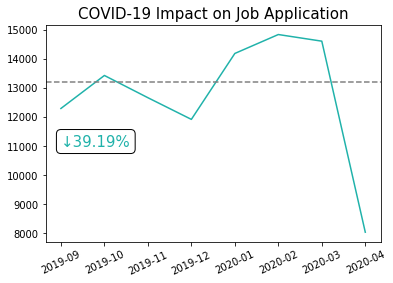

In [14]:
#job application
plt.plot("month_name", "jobApplication", data = d, color = "lightseagreen") 

#average job applications before March 2020
plt.axhline(y = avg_number,ls = "dashed",color = "grey") 

#title
plt.title("COVID-19 Impact on Job Application",fontsize = 15)

#annotaion: falling rate
bbox_props = dict(boxstyle="round", facecolor = "white")
plt.text(0, 11000, falling_rate_str, size = 15, color = "lightseagreen", bbox=bbox_props)

plt.xticks(rotation=25)